# Simulate a binary entry game.

This notebook shows how to build payoffs, solve for equilibrium CCPs, and plot them.


Equilibrium CCP shape: (25, 1, 2)


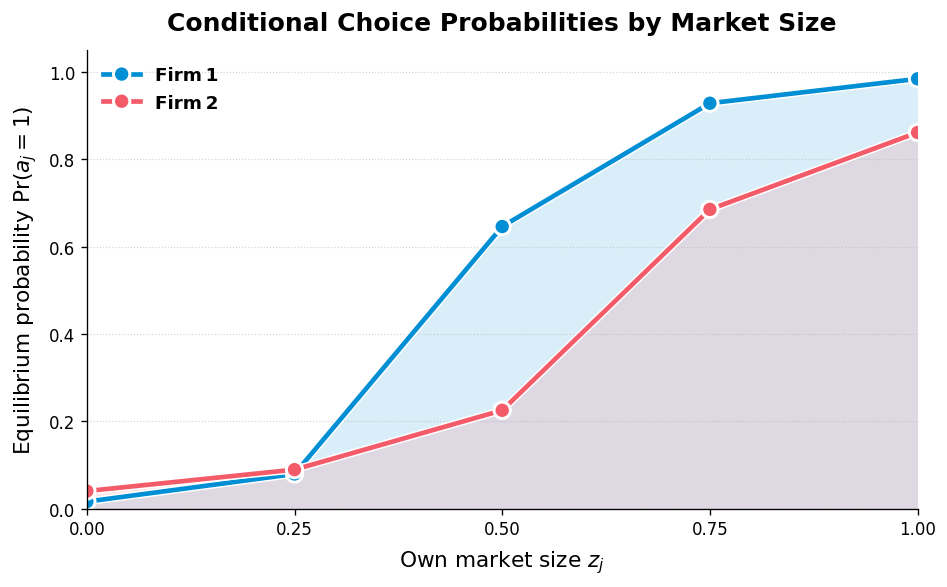

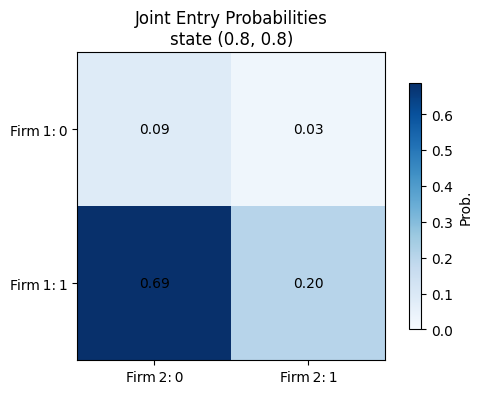

In [2]:
# %%
# 01_simulate_game.py
#
# Simulate a simple two–firm entry game, solve for equilibrium CCPs,
# and visualise the results.

# Author: Mirko De Maria (July 2025)
# m.de-maria@imperial.ac.uk
# mirkodemaria.com
"""
# 01 Simulate a Binary Entry Game

This notebook shows how to:

* Build pay-off parameters for a 2-player static entry game  
* Solve for equilibrium conditional choice probabilities (CCPs)  
* Plot CCPs as functions of a state variable  
* Visualise the joint action distribution with a heat-map
"""
# %%
import sys, pathlib, os
# Path to the *src* directory that contains some packages
root = pathlib.Path().resolve()
src_path = root.parent / "src"        
sys.path.append(str(src_path))
import numpy as np
import matplotlib.pyplot as plt
from discrete_game_identification import (
    solve_equilibrium,
    compute_joint_distribution,
)

# set plotting parameters
plt.rcParams["figure.figsize"] = (6, 4)

# %% 1  Model dimensions and state grid
nplayers   = 2                       # two firms in the game
num_z      = 5                       # five discrete market sizes
num_kappa  = 1                       # single latent type for now
zvals      = np.linspace(0, 1, num_z)

# %% 2  Pay‑off parameters  α + β · p_opponent
alpha = np.zeros((nplayers, num_z, num_kappa))
beta  = np.zeros((nplayers, nplayers, num_z, num_kappa))

# Firm A: large fixed cost but benefits strongly from market size
alpha[0, :, 0] = -1.5 + 6.0 * zvals
beta[0, 1, :, 0] = -4.0              # strongly dislikes rival entry

# Firm B: lower fixed cost, weaker market‑size slope
alpha[1, :, 0] = -0.8 + 3.0 * zvals
beta[1, 0, :, 0] = -3.0

# %% 3  Solve equilibrium CCPs
p_equil = solve_equilibrium(alpha, beta) 
num_states = num_z ** nplayers
print("Equilibrium CCP shape:", p_equil.shape)

# %% 4  Plot CCPs as a function of own market size z_j
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

# --- Style parameters -------------------------------------------------------
colors = ["#008FD5", "#F45B69"]      
lw      = 2.8                        
mksize  = 7     
halo    = [pe.Stroke(linewidth=lw+1.8, foreground="white"), pe.Normal()]

state_tuples = list(np.ndindex((num_z, num_z)))

for player, color in enumerate(colors):
    # keep rival’s z at the median
    mask   = [st[1 - player] == num_z // 2 for st in state_tuples]
    z_grid = zvals[[st[player] for i, st in enumerate(state_tuples) if mask[i]]]
    probs  = p_equil[mask, 0, player]

    ax.plot(z_grid, probs,
            marker="o", markersize=mksize, linewidth=lw,
            color=color, label=f"Firm {player+1}",
            path_effects=halo)
    ax.fill_between(z_grid, 0, probs,
                    color=color, alpha=0.15, linewidth=0)

# --- Cosmetics --------------------------------------------------------------
ax.set_xlabel(r"Own market size $z_j$", fontsize=13, labelpad=6)
ax.set_ylabel(r"Equilibrium probability $\Pr(a_j=1)$", fontsize=13, labelpad=6)
ax.set_title("Conditional Choice Probabilities by Market Size",
             fontsize=15, weight="bold", pad=12)

ax.set_ylim(0, 1.05)
ax.set_xlim(zvals.min(), zvals.max())
ax.set_xticks(zvals)

# tidy grid & frame
ax.grid(axis="y", linestyle=":", linewidth=0.7, alpha=0.55)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# legend with matching style
leg = ax.legend(frameon=False, fontsize=11, loc="upper left")
for txt in leg.get_texts():
    txt.set_fontweight("bold")

fig.tight_layout()
plt.show()

# %% 5  Joint action heat‑map for a representative state (z1=0.8, z2=0.8)
# choose the state index closest to z=0.8 for both firms
target = (np.abs(zvals - 0.8)).argmin()
state_idx = target + target * num_z
Q, acts = compute_joint_distribution(p_equil, np.ones((num_states,1)))
Q_state = Q[state_idx]

# build 2×2 table
heat = np.array([[Q_state[0], Q_state[1]],   # (0,0)  (0,1)
                 [Q_state[2], Q_state[3]]])  # (1,0)  (1,1)

fig, ax = plt.subplots()
im = ax.imshow(heat, cmap="Blues", vmin=0, vmax=heat.max())
ax.set_xticks([0, 1], labels=["Firm 2: 0", "Firm 2: 1"])
ax.set_yticks([0, 1], labels=["Firm 1: 0", "Firm 1: 1"])
ax.set_title("Joint Entry Probabilities\nstate (0.8, 0.8)")
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{heat[i, j]:.2f}", ha="center", va="center")
plt.colorbar(im, shrink=.8, label="Prob.")
plt.show()
